In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import os

project_folder = "/content/drive/MyDrive/Colab_Notebooks/Project"
spectrogram_folder = os.path.join(project_folder, 'spectrograms')

In [72]:
import cv2

IMG_HEIGHT = 64
IMG_WIDTH = 64
dataset = []

def get_images_labels(file_folder):
  for root, directory, filenames in os.walk(file_folder):
    for filename in filenames:
      if filename.endswith("png"):
        read_images = cv2.imread(os.path.join(root, filename), 1)  # 0: cv2.IMREAD_GRAYSCALE; 1: cv2.IMREAD_COLOR; -1: cv2.IMREAD_UNCHANGED                                          
        read_images = cv2.resize(read_images, dsize=(IMG_WIDTH, IMG_HEIGHT))  # resizing; interpolation=cv2.INTER_AREA
        read_images = cv2.cvtColor(read_images, cv2.COLOR_BGR2GRAY)  #grayscaling
        label_name = os.path.basename(root)
        grayscale_images = read_images / 255  # normalizing
        dataset.append([grayscale_images, label_name])
  return dataset

In [73]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def data_preprocessing():
  encoder = LabelEncoder()
  obj_data = get_images_labels(spectrogram_folder)

  image_data = np.array([obj_data[image_loc][0] for image_loc in range(len(obj_data))])
  image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)

  label_data = np.array([obj_data[image_loc][1] for image_loc in range(len(obj_data))])
  label_data = encoder.fit_transform(label_data)

  X_train, X_test, y_train, y_test = train_test_split(image_data, label_data, train_size=0.87, random_state=42)

  X_val = X_train[6460:]
  y_val = y_train[6460:]
  X_train = X_train[:6460]
  y_train = y_train[:6460]

  return X_train, X_test, X_val, y_train, y_test, y_val

In [74]:
x_train, x_test, x_val, y_train, y_test, y_val = data_preprocessing()

In [75]:
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

# Print the lengths of the each dataset
print(f"\nX_train: {len(x_train)}")
print(f"y_train: {len(y_train)}")
print(f"X_val: {len(x_val)}")
print(f"y_val: {len(y_val)}")
print(f"x_test: {len(x_test)}")
print(f"y_test: {len(y_test)}")

(6460, 64, 64, 1) (1136, 64, 64, 1)
(6460,) (1136,)

X_train: 6460
y_train: 6460
X_val: 1136
y_val: 1136
x_test: 1136
y_test: 1136


In [76]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential,optimizers


def create_model(kernel_size: tuple, input_shape: tuple):
  model = Sequential()
  model.add(Conv2D(IMG_WIDTH,
                  kernel_size=kernel_size,
                  strides=(1,1),
                  padding="same",
                  activation="relu",
                  input_shape=input_shape)           
  )
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(IMG_WIDTH/2,
                  kernel_size=kernel_size,
                  strides=(1,1),
                  padding="same",
                  activation="relu",
                  input_shape=input_shape)           
  )

  model.add(Flatten())
  model.add(Dense(64, activation='relu')),
  model.add(Dropout(0.4))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=optimizers.Adam(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  return model

In [77]:
my_model = create_model((3, 3), (IMG_WIDTH, IMG_HEIGHT, 1))
results = my_model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data = (x_val, y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


202/202 [==============================] - 3s 10ms/step - loss: 2.1086 - accuracy: 0.2330 - val_loss: 1.8172 - val_accuracy: 0.3741
Epoch 2/50
202/202 [==============================] - 2s 8ms/step - loss: 1.8564 - accuracy: 0.3320 - val_loss: 1.5401 - val_accuracy: 0.4824
Epoch 3/50
202/202 [==============================] - 2s 9ms/step - loss: 1.6702 - accuracy: 0.4101 - val_loss: 1.4023 - val_accuracy: 0.5343
Epoch 4/50
202/202 [==============================] - 2s 8ms/step - loss: 1.5581 - accuracy: 0.4539 - val_loss: 1.2668 - val_accuracy: 0.6004
Epoch 5/50
202/202 [==============================] - 2s 8ms/step - loss: 1.4710 - accuracy: 0.4867 - val_loss: 1.1746 - val_accuracy: 0.6576
Epoch 6/50
202/202 [==============================] - 2s 8ms/step - loss: 1.3835 - accuracy: 0.5259 - val_loss: 1.1174 - val_accuracy: 0.6585
Epoch 7/50
202/202 [==============================] - 2s 8ms/step - loss: 1.3052 - accuracy: 0.5546 - val_loss: 1.0367 - val_accuracy: 0.6919
Epoch 8/50
202/2

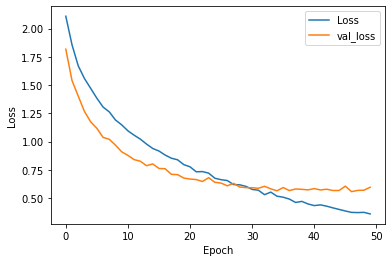

In [78]:
import matplotlib.pyplot as plt

plt.plot(results.history["loss"], label="Loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

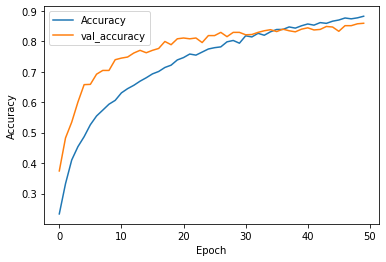

In [79]:
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [80]:
# Evaluate the performance
my_model.evaluate(x_test, y_test)

36/36 [==============================] - 0s 5ms/step - loss: 0.4742 - accuracy: 0.8556


[0.4742164611816406, 0.8556337952613831]

[[1.1820870e-03 2.6668648e-03 1.6384402e-03 7.2959845e-04 1.8437070e-01
  2.2794376e-03 2.9834558e-04 8.0170125e-01 2.4338462e-03 2.6993921e-03]]


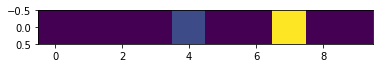

In [81]:
prediction_result = my_model.predict(x_test[545].reshape(1,IMG_WIDTH,IMG_HEIGHT,1))
plt.imshow(prediction_result)
print(prediction_result)

In [82]:
predicted_folder = prediction_result.argmax()
predicted_probability = prediction_result.max()

In [83]:
print(f"This image belongs to folder {predicted_folder} with {predicted_probability}% probability")

This image belongs to folder 7 with 0.8017012476921082% probability
